<a href="https://colab.research.google.com/github/cheryleugene88/skills-introduction-to-github/blob/main/AOL_Machine_Learning_Letter_Recognition_Project_Hugging_Face_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Models
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier # Pengganti CNN untuk data tabular
from sklearn.naive_bayes import GaussianNB

# Preprocessing & Metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [5]:
from datasets import load_dataset

df = load_dataset("pittawat/letter_recognition")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
print(df)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 26000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2600
    })
})


In [7]:
def preprocess_hf_dataset(ds_split):
    """
    Mengubah format dataset Hugging Face (Image) menjadi Numpy Array (Tabular).
    Input: Dataset split (misal: dataset['train'])
    Output: X (Features), y (Labels)
    """
    images = []
    labels = []

    print(f"Memproses {len(ds_split)} data...")

    for item in ds_split:
        # 1. Ambil gambar dan ubah ke numpy array
        img_array = np.array(item['image'])

        # 2. FLATTENING: Ubah dari 28x28 (2D) menjadi 784 (1D vector)
        # Ini agar bisa masuk ke SVM/RF/XGBoost yang butuh input tabular
        img_flat = img_array.flatten()

        # 3. NORMALISASI MANUAL (Opsional di sini, tapi bagus untuk hemat memori)
        # Pixel 0-255 diubah jadi 0-1
        img_norm = img_flat / 255.0

        images.append(img_norm)
        labels.append(item['label'])

    return np.array(images), np.array(labels)

In [8]:
print("\nMelakukan Preprocessing Data Train...")
X_train, y_train = preprocess_hf_dataset(df['train'])

print("Melakukan Preprocessing Data Test...")
# Cek apakah ada split 'test', jika tidak ada kita split manual nanti
if 'test' in df:
    X_test, y_test = preprocess_hf_dataset(df['test'])
else:
    print("Split 'test' tidak ditemukan, akan melakukan split manual dari train.")
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )


Melakukan Preprocessing Data Train...
Memproses 26000 data...
Melakukan Preprocessing Data Test...
Memproses 2600 data...



=== HASIL PREPROCESSING ===
Shape X_train: (26000, 2352) (Jumlah Data, Jumlah Pixel/Fitur)
Shape y_train: (26000,)
Shape X_test : (2600, 2352)
Shape y_test : (2600,)
Contoh Label: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


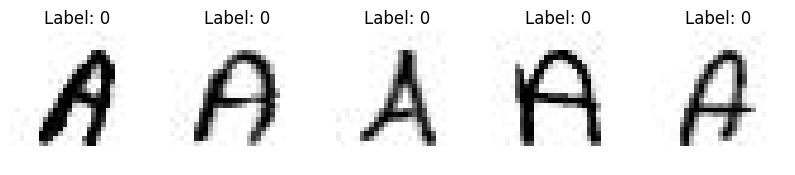

In [9]:
print("\n=== HASIL PREPROCESSING ===")
print(f"Shape X_train: {X_train.shape} (Jumlah Data, Jumlah Pixel/Fitur)")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape X_test : {X_test.shape}")
print(f"Shape y_test : {y_test.shape}")

# Pastikan labelnya integer (0-25)
print(f"Contoh Label: {np.unique(y_train)}")

# --- VISUALISASI CONTOH DATA (Opsional) ---
# Untuk memastikan data benar
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Reshape kembali ke 28x28 untuk ditampilkan
    plt.imshow(X_train[i].reshape(28, 28, 3), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

# Training Data

### SVM Classifier

In [10]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)

### KNN Classifier

In [11]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)

### Decision Tree Classifier

In [12]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
decision_tree_predictions = decision_tree_model.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)

### Random Forest Classfier

In [13]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

## Ensemble Tree Classifier

### XGBoost Classifier

In [14]:
xgb_model = XGBClassifier(
    n_estimators=200,       # jumlah pohon
    max_depth=6,            # kedalaman pohon
    learning_rate=0.1,      # step size
    subsample=0.8,          # sampling data
    colsample_bytree=0.8,   # sampling fitur
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9203846153846154


## LightGBM Classifier

In [15]:
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=-1,           # -1 = tidak dibatasi
    learning_rate=0.1,
    num_leaves=31,          # jumlah daun per pohon
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.367683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271521
[LightGBM] [Info] Number of data points in the train set: 26000, number of used features: 1728
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[LightGBM] [Info] Start training from score -3.258097
[Ligh

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9296153846153846


### Naive Bayes classifier

In [16]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)

### Deep learning MLP

In [17]:
# Import library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# --- 3. MLP Classifier ---
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # 2 hidden layers: 100 neuron & 50 neuron
    max_iter=500,                  # jumlah iterasi training
    activation='relu',             # fungsi aktivasi (default: relu)
    solver='adam',                 # optimizer (default: adam)
    random_state=42
)

mlp_model.fit(X_train, y_train)
mlp_predictions = mlp_model.predict(X_test)

# --- 4. Evaluasi ---
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)

MLP Accuracy: 0.9080769230769231


In [18]:
print("SVM Accuracy:", svm_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Decision Tree Accuracy:", decision_tree_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("Naive Bayes Accuracy:", nb_accuracy)
print("MLP (Deep learning) Accuracy:", mlp_accuracy)

SVM Accuracy: 0.938076923076923
KNN Accuracy: 0.8961538461538462
Decision Tree Accuracy: 0.6796153846153846
Random Forest Accuracy: 0.9030769230769231
XGBoost Accuracy: 0.9203846153846154
LightGBM Accuracy: 0.9296153846153846
Naive Bayes Accuracy: 0.5876923076923077
MLP (Deep learning) Accuracy: 0.9080769230769231


In [19]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline # Added import for Pipeline

# Define pipelines as per model_configs for consistency with hyperparameter tuning setup
# Note: StandardScaler and all model classes (SVC, KNeighborsClassifier, etc.) are already imported in the initial setup cell.

pipe_svm = Pipeline([('scaler', StandardScaler()), ('clf', svm.SVC(random_state=42))])
pipe_knn = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])
pipe_decision_tree = Pipeline([('clf', DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42))])
pipe_xgb = Pipeline([('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))])
pipe_lgbm = Pipeline([('clf', LGBMClassifier(random_state=42, verbose=-1))])
pipe_nb = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
pipe_mlp = Pipeline([('scaler', StandardScaler()), ('clf', MLPClassifier(max_iter=500, random_state=42))])


# 1. Siapkan Strategy CV (Stratified agar proporsi huruf A-Z seimbang tiap fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Masukkan semua model ke dalam Dictionary agar coding lebih rapi & tidak berulang
# Pastikan variabel model (pipe_svm, pipe_knn, dll) sudah didefinisikan sebelumnya
models = {
    "SVM": pipe_svm,
    "KNN": pipe_knn,
    "Decision Tree": pipe_decision_tree,
    "Random Forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "Naive Bayes": pipe_nb,
    "MLP (Deep Learning)": pipe_mlp
}

print(f"{'Model Name':<25} | {'CV Accuracy (Mean)':<20} | {'Stability (Std Dev)'}")
print("-" * 65)

# 3. Loop untuk menghitung score masing-masing
results = []
names = []

for name, model in models.items():
    # Menghitung 5 scores berbeda untuk setiap model
    # n_jobs=-1 artinya menggunakan semua core CPU agar lebih cepat
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

    # Simpan hasil untuk visualisasi nanti
    results.append(scores)
    names.append(name)

    # Print hasil format rapi
    print(f"{name:<25} | {scores.mean():.4f}               | +/- {scores.std():.4f}")

Model Name                | CV Accuracy (Mean)   | Stability (Std Dev)
-----------------------------------------------------------------
SVM                       | 0.9311               | +/- 0.0052
KNN                       | 0.8677               | +/- 0.0024
Decision Tree             | 0.6697               | +/- 0.0067
Random Forest             | 0.9135               | +/- 0.0041


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGBoost                   | 0.9140               | +/- 0.0045


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


LightGBM                  | 0.9272               | +/- 0.0054
Naive Bayes               | 0.5500               | +/- 0.0159
MLP (Deep Learning)       | 0.9141               | +/- 0.0034


## Hyperparameter Tuning

### SVM Classifier

In [20]:
model_configs = [] # Initialize the list
model_configs.append({
    'name': 'SVM',
    'pipeline': Pipeline(
        [('scaler', StandardScaler()),
         ('clf', SVC())
        ]),
    'param_grid': {
        'clf__C': [0.1, 1, 10, 100, 1000],            # C besar = penalty kesalahan tinggi (lebih ketat)
        'clf__gamma': ['scale','auto', 1, 0.1, 0.01, 0.001], # Gamma mengatur jangkauan pengaruh data training
        'clf__kernel': ['rbf', 'poly']             # RBF biasanya terbaik untuk Letter Recognition
    }
})

### KNN Classifier

In [21]:
model_configs.append({
    'name': 'KNN',
    'pipeline': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),
    'param_grid': {
        'clf__n_neighbors': [3, 5, 7, 11],
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2]  # Manhattan vs Euclidean
    }
})

### Decision Tree Classifier

In [22]:
model_configs.append({
    'name': 'DecisionTree',
    'pipeline': Pipeline([
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    'param_grid': {
        'clf__criterion': ['gini', 'entropy'],   # Fungsi impurity
        'clf__max_depth': [None, 10, 20, 50],    # Kedalaman pohon
        'clf__min_samples_split': [2, 5, 10],    # Minimum sampel untuk split
        'clf__min_samples_leaf': [1, 2, 4],      # Minimum sampel per daun
        'clf__max_features': [None, 'sqrt', 'log2'] # Fitur yang dipertimbangkan per split
    }
})

### Random Forest

In [23]:
model_configs.append({
    'name': 'RandomForest',
    'pipeline': Pipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'param_grid': {
        'clf__n_estimators': [100, 200, 500],
        'clf__max_depth': [None, 10, 20, 50],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }
})

### XGBoost Classifier

In [24]:
model_configs.append({
    'name': 'XGBoost',
    'pipeline': Pipeline([
        ('clf', XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42,
            tree_method='hist'   # lebih cepat untuk dataset besar
        ))
    ]),
    'param_grid': {
        'clf__learning_rate': [0.05, 0.1],       # step size kecil → stabil
        'clf__n_estimators': [100, 200],         # jumlah boosting rounds
        'clf__max_depth': [3, 6],                # kontrol kompleksitas pohon
        'clf__subsample': [0.8, 1.0],            # sampling row untuk regularisasi
        'clf__colsample_bytree': [0.8, 1.0]      # sampling fitur per tree
    }
})

### LightGBM Classifier

In [25]:
model_configs.append({
    'name': 'LightGBM',
    'pipeline': Pipeline([
        ('clf', LGBMClassifier(
            random_state=42,
            verbose=-1,
            boosting_type='gbdt'   # default, paling umum untuk klasifikasi
        ))
    ]),
    'param_grid': {
        'clf__learning_rate': [0.05, 0.1],       # step size kecil → stabil
        'clf__n_estimators': [100, 200],         # jumlah boosting rounds
        'clf__num_leaves': [31, 50],             # kontrol kompleksitas pohon
        'clf__max_depth': [-1, 10, 20],          # -1 = unlimited, batasi untuk cegah overfitting
        'clf__subsample': [0.8, 1.0],            # sampling row untuk regularisasi
        'clf__colsample_bytree': [0.8, 1.0]      # sampling fitur per tree
    }
})

### Naive Bayes Classifier

In [26]:
model_configs.append({
    'name': 'Naive Bayes',
    'pipeline': Pipeline([
        ('scaler', StandardScaler()),   # scaling membantu distribusi Gaussian lebih stabil
        ('clf', GaussianNB())
    ]),
    'param_grid': {
        'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # range kecil untuk stabilitas numerik
    }
})

### MLP (Deep Learning) Classifier

In [27]:
model_configs.append({
    'name': 'MLP (Deep Learning)',
    'pipeline': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(
            max_iter=300,        # kurangi iterasi agar lebih cepat
            early_stopping=True, # berhenti otomatis jika validasi tidak membaik
            random_state=42
        ))
    ]),
    'param_grid': {
        'clf__hidden_layer_sizes': [(100,), (100, 50)],   # batasi kombinasi layer
        'clf__activation': ['relu'],                      # relu biasanya lebih stabil
        'clf__alpha': [0.0001, 0.001]                     # regularisasi ringan
    }
})

In [ ]:
from sklearn.model_selection import GridSearchCV

best_models = {} # Untuk menyimpan model terbaik hasil tuning

print("Mulai Hyperparameter Tuning...")
print("Catatan: Proses ini bisa memakan waktu 30-60 menit tergantung spesifikasi komputer Anda.")
print("="*60)

for config in model_configs:
    name = config['name']
    pipeline = config['pipeline']
    params = config['param_grid']

    print(f"\nSedang tuning: {name}...")

    # Setup GridSearchCV
    # cv=3 untuk mempercepat proses tuning (standar riset biasanya 5)
    # n_jobs=-1 artinya pakai SEMUA core CPU yang tersedia (Paralel)
    grid = GridSearchCV(pipeline, params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

    # Fit data train
    grid.fit(X_train, y_train)

    # Simpan hasil
    best_models[name] = grid.best_estimator_

    print(f"  -> Best Params: {grid.best_params_}")
    print(f"  -> Best CV Accuracy: {grid.best_score_:.4f}")

print("\n" + "="*60)
print("Tuning Selesai!")

Mulai Hyperparameter Tuning...
Catatan: Proses ini bisa memakan waktu 30-60 menit tergantung spesifikasi komputer Anda.

Sedang tuning: SVM...
Fitting 3 folds for each of 60 candidates, totalling 180 fits


In [ ]:
def plot_confusion_matrix(model_name, model_object, X_test, y_test, classes):
    """
    Fungsi custom untuk plot confusion matrix 26x26 yang rapi
    """
    y_pred = model_object.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(14, 12)) # Ukuran besar agar huruf terbaca
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label (Actual)')
    plt.xlabel('Predicted Label')
    plt.show()

# CONTOH PENGGUNAAN:
# Ganti 'XGBoost' dengan nama model lain yang ada di best_models (misal 'SVM', 'Random Forest')
# Kita ambil model terbaik (urutan pertama di leaderboard)
best_model_name = df_results.iloc[0]['Model']
best_model_obj = best_models[best_model_name]

print(f"Menampilkan Confusion Matrix untuk Model Terbaik: {best_model_name}")
plot_confusion_matrix(best_model_name, best_model_obj, X_test, y_test, le.classes_)

In [ ]:
# 1. Binarize Label Test (Ubah y_test jadi format One-Hot Encoding)
# Bentuknya jadi matriks (n_samples, 26) berisi 0 dan 1
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

plt.figure(figsize=(10, 8))

# 2. Loop untuk setiap model
for name, model in best_models.items():

    # Cek apakah model support probability
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"): # Untuk SVM jika probability=False
        y_score = model.decision_function(X_test)
    else:
        print(f"Model {name} tidak support probability scores, skip ROC.")
        continue

    # 3. Hitung ROC untuk setiap kelas, lalu ambil rata-rata (Macro Average)
    # Ini teknik standar untuk menyederhanakan plot multi-class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute Macro-Average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # 4. Plot Garis Model Tersebut
    plt.plot(all_fpr, mean_tpr,
             label=f'{name} (Macro AUC = {macro_auc:.4f})',
             linewidth=2)

# Dekorasi Plot
plt.plot([0, 1], [0, 1], 'k--', lw=2) # Garis diagonal random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve Comparison (One-vs-Rest Macro Average)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()